# Goals

### - Identify what is driving log error
### - Build a model to accurately predict the log error

# Hypotheses
What we think causes log error:
- Location: certain geographic areas may be harder to accurately predict than others. Log error may differ by County. 
- Property Value: higher valued properties may have more variance which makes them harder to predict
- Age of Property: newer homes may be similarily built, thus easier to predict price. Older property values may have more variance, thus making them harder to predict
- Amenities: fireplace, pool, hot tub, and garage are nice amenities that not all properties include. These amenities may be driving log error by making property values harder to predict.
- Data density: geographic areas with more data points (higher data density) will have lower log errors. Geogrphaic areas with less data points (lower data density) will have higher log errors. The more data we have in a given geographic area, the lower we would expect those log errors to be.

## Set up Environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="white", palette="muted")
#import acquire
import prep
import split_scale
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# Acquire

### Here we acquire our data from the SQL database. We have already chosen to filter on the following conditions:
- Only include properties containing latitude and longitude values.
- Only include properties with a transaction in 2017 (including the most recent transaction date to avoid duplicates).
- Only include single unit properties. 
  - Single unit property: a free standing property in which the owner also owns the land beneath the property. A single unit property is built for the use of one family (i.e. does not include duplexes, triplexes, etc.)

In [2]:
data = pd.read_csv('query_result.csv')

Preview data:

In [3]:
data.shape

(52357, 61)

In [4]:
data.head(5)

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,14297519,1727539,NaN,NaN,NaN,3.5,4,NaN,NaN,3.5,...,485713.0,1023282.0,2016,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01
1,17052889,1387261,NaN,NaN,NaN,1.0,2,NaN,NaN,1.0,...,88000.0,464000.0,2016,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01
2,14186244,11677,NaN,NaN,NaN,2.0,3,NaN,NaN,2.0,...,85289.0,564778.0,2016,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01
3,12177905,2288172,NaN,NaN,NaN,3.0,4,NaN,8.0,3.0,...,108918.0,145143.0,2016,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01
4,12095076,781532,1.0,NaN,NaN,3.0,4,NaN,9.0,3.0,...,276684.0,773303.0,2016,496619.0,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01


In [5]:
data.columns

Index(['parcelid', 'id', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardb

# Prepare
### There are several rows and columns that are missing data. We need to treat null values by dropping columns, dropping rows, or imputing missing values.

### Preview nulls

This function shows the amount of rows that have null values for each column. We use this to check if there are any columns that are droppable due to a large portion of nulls.

In [6]:
prep.nulls_by_col(data)

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
id,0,0.000000
airconditioningtypeid,38738,0.739882
architecturalstyletypeid,52287,0.998663
basementsqft,52310,0.999102
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingclasstypeid,52357,1.000000
buildingqualitytypeid,18692,0.357011
calculatedbathnbr,162,0.003094


This function shows the amount of rows that are missing a certain number of columns. We use this to check if there are any rows that are missing so many columns, they are not worth keeping.
We will drop columns first, and then come back and check these rows to see how they were affected.

In [7]:
prep.nulls_by_row(data)

,num_cols_missing,pct_cols_missing,num_rows
0,19,31.147540983606557,2
1,20,32.78688524590164,10
2,21,34.42622950819672,83
3,22,36.0655737704918,261
4,23,37.704918032786885,480
5,24,39.34426229508197,534
6,25,40.98360655737705,2910
7,26,42.62295081967213,5921
8,27,44.26229508196721,7934
9,28,45.90163934426229,15854


### Run data through our prep function to acheive the following:
- fills nulls in taxdelinquencyflag with 'N'
- fills nulls with zero for fireplacecnt, garagecarcnt, poolcnt, and taxdelinquencyyear
- drops 28 columns due to excess nulls and irrelevency
- encodes the fips columns
- data shape transformed from 52357 rows x 61 columns to 46649 rows x 33 columns

In [8]:
data = prep.prep_zillow(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52357 entries, 0 to 52356
Data columns (total 61 columns):
parcelid                        52357 non-null int64
id                              52357 non-null int64
airconditioningtypeid           13619 non-null float64
architecturalstyletypeid        70 non-null float64
basementsqft                    47 non-null float64
bathroomcnt                     52357 non-null float64
bedroomcnt                      52357 non-null int64
buildingclasstypeid             0 non-null float64
buildingqualitytypeid           33665 non-null float64
calculatedbathnbr               52195 non-null float64
decktypeid                      389 non-null float64
finishedfloor1squarefeet        4371 non-null float64
calculatedfinishedsquarefeet    52250 non-null float64
finishedsquarefeet12            52084 non-null float64
finishedsquarefeet13            0 non-null float64
finishedsquarefeet15            0 non-null float64
finishedsquarefeet50            4371 n

In [9]:
data.shape

(46756, 21)

In [10]:
data.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'fireplacecnt', 'garagecarcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'poolcnt', 'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'taxvaluedollarcnt', 'taxdelinquencyflag', 'taxdelinquencyyear',
       'logerror'],
      dtype='object')

In [11]:
data.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                        int64
calculatedfinishedsquarefeet    float64
fips                              int64
fireplacecnt                    float64
garagecarcnt                    float64
latitude                          int64
longitude                         int64
lotsizesquarefeet               float64
poolcnt                         float64
propertylandusetypeid             int64
regionidcity                    float64
regionidcounty                    int64
regionidzip                     float64
roomcnt                           int64
yearbuilt                       float64
taxvaluedollarcnt               float64
taxdelinquencyflag                int64
taxdelinquencyyear              float64
logerror                        float64
dtype: object

In [12]:
data.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,...,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,logerror
1,17052889,1.0,2,1465.0,2,1.0,1.0,34449266,-119281531,12647.0,...,261,13091.0,2061,97099.0,5,1967.0,464000.0,0,0.0,0.055619
2,14186244,2.0,3,1243.0,1,0.0,2.0,33886168,-117823170,8432.0,...,261,21412.0,1286,97078.0,6,1962.0,564778.0,0,0.0,0.005383
3,12177905,3.0,4,2376.0,0,0.0,0.0,34245180,-118240722,13038.0,...,261,396551.0,3101,96330.0,0,1970.0,145143.0,0,0.0,-0.103410
4,12095076,3.0,4,2962.0,0,0.0,0.0,34145202,-118179824,63000.0,...,261,47019.0,3101,96293.0,0,1950.0,773303.0,0,0.0,-0.001011
5,12069064,1.0,2,738.0,0,0.0,0.0,34149214,-118239357,4214.0,...,261,45457.0,3101,96325.0,0,1922.0,218552.0,0,0.0,0.101723


# Explore
To do:

- Check our hypotheses
- t tests
- chi square test
- clustering

Simple correlation matrix

In [13]:
data.corr()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,...,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,logerror
parcelid,1.000000,0.067556,0.074868,0.072101,0.529092,0.339291,0.445554,-0.169301,-0.072063,-0.013919,...,0.006671,-0.027347,-0.387681,0.028324,0.424093,0.164711,0.088846,-0.044317,-0.044091,0.007230
bathroomcnt,0.067556,1.000000,0.624234,0.799004,0.158046,0.160012,0.220746,0.049647,0.005006,0.014869,...,0.043571,-0.060170,-0.161191,0.033891,0.132278,0.540522,0.399990,-0.060032,-0.057925,0.027636
bedroomcnt,0.074868,0.624234,1.000000,0.629117,0.156628,0.151163,0.199923,0.048408,-0.007811,0.001828,...,0.060512,-0.049474,-0.140770,0.021056,0.203176,0.371836,0.236200,-0.045336,-0.044308,0.039754
calculatedfinishedsquarefeet,0.072101,0.799004,0.629117,1.000000,0.162633,0.199747,0.227626,0.031712,-0.002917,0.025447,...,-0.004926,-0.058061,-0.158700,0.029220,0.149093,0.475770,0.460109,-0.049351,-0.047788,0.027443
fips,0.529092,0.158046,0.156628,0.162633,1.000000,0.620868,0.872777,-0.239963,-0.192006,-0.016702,...,0.013060,-0.062120,-0.793113,0.054662,0.831342,0.327296,0.188679,-0.080075,-0.079558,0.012689
fireplacecnt,0.339291,0.160012,0.151163,0.199747,0.620868,1.000000,0.534191,-0.066052,-0.224796,-0.003863,...,0.008208,-0.027174,-0.409872,0.029183,0.619804,0.203245,0.165260,-0.051517,-0.050704,0.000632
garagecarcnt,0.445554,0.220746,0.199923,0.227626,0.872777,0.534191,1.000000,-0.435377,0.131245,-0.019327,...,0.014942,-0.070075,-0.907746,0.055704,0.810130,0.373620,0.233785,-0.081790,-0.080438,0.013678
latitude,-0.169301,0.049647,0.048408,0.031712,-0.239963,-0.066052,-0.435377,1.000000,-0.531718,0.056274,...,-0.007823,-0.017105,0.572667,0.018068,-0.306809,0.111885,-0.175405,0.035346,0.034828,-0.011473
longitude,-0.072063,0.005006,-0.007811,-0.002917,-0.192006,-0.224796,0.131245,-0.531718,1.000000,-0.010717,...,-0.002308,-0.006678,-0.341575,0.028224,-0.018859,0.078307,0.003146,0.004240,0.005001,0.013516
lotsizesquarefeet,-0.013919,0.014869,0.001828,0.025447,-0.016702,-0.003863,-0.019327,0.056274,-0.010717,1.000000,...,0.000077,-0.009244,0.024580,0.004698,-0.015408,0.029830,-0.001680,-0.000874,-0.000714,0.008460


| Variable | Logerror Correlation (absolute value)   |
|----|----|
|logerror| 1|
|bedroomcnt|	0.039754|
|poolcnt	|0.036842|
|taxvaluedollarcnt|	0.02888|
|bathroomcnt|	0.027636|
|calculatedfinishedsquarefeet|	0.027443|
|taxdelinquencyflag|	0.025705|
|taxdelinquencyyear|	0.020211|
|regionidcounty|	0.017184|
|yearbuilt|	0.015641|
|roomcnt|	0.014843|
|garagecarcnt|	0.013678|
|longitude|	0.013516|
|fips|	0.012689|
|latitude|	0.011473|
|propertylandusetypeid|	0.009699|
|lotsizesquarefeet|	0.00846|
|parcelid|	0.00723|
|regionidcity|	0.004214|
|regionidzip|	0.001032|
|fireplacecnt|	0.000632|

### Hypothesis 1: Location

### Hypothesis 2: Property Value

fips
0    0.011911
1    0.016421
2    0.013860
Name: logerror, dtype: float64
0    30463
1    12259
2     4034
Name: fips, dtype: int64


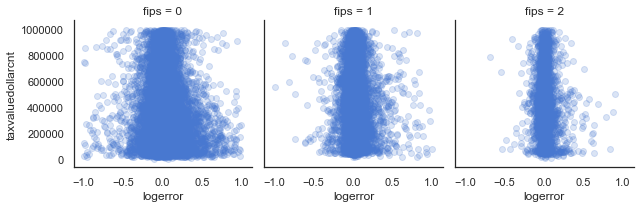

In [14]:
print(data.groupby('fips')['logerror'].mean())
print(data['fips'].value_counts())

g = sns.FacetGrid(data, col = 'fips')
g = g.map(plt.scatter, 'logerror', 'taxvaluedollarcnt', alpha = .2)

### Hypothesis 3: Age of Property

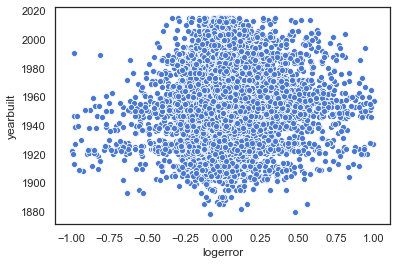

In [15]:
sns.scatterplot(x='logerror',y='yearbuilt', data = data)

### Hypothesis 4: Amenities

### Hypothesis 5: Data Density

# Model 

## Split Data

In [16]:
train, test = split_scale.split_my_data(data)

In [17]:
X_train = train.drop(columns=['logerror'])
y_train = train['logerror']

In [18]:
X_test = test.drop(columns=['logerror'])
y_test = test['logerror']

## Scale Data

In [19]:
X_train_scaled = split_scale.min_max_scaler(X_train)

In [22]:
X_train_scaled

pandas.core.frame.DataFrame

### Model 1
- Linear regression with all features

In [25]:
lm1=LinearRegression()
lm1.fit(X_train_scaled, y_train)
yhat_lm1=lm1.predict(X_train_scaled)
yhat_lm1

array([ 0.02010435,  0.00652998,  0.00639626, ...,  0.0254652 ,
        0.00140753, -0.00127946])

In [26]:
MSE_1 = mean_squared_error(yhat_lm1, y_train)
RMSE_1 = sqrt(MSE_1)
print(RMSE_1)

0.11275012133657092


### Model 2
- Linear regression with top 6 features: bedroomcnt, poolcnt, taxvaluedollarcnt, bathroomcnt, calculatedfinishedsquarefeet, taxdelinquencyflag

In [27]:
X_train_2 = X_train_scaled[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
lm2=LinearRegression()
lm2.fit(X_train_2,y_train)
yhat_lm2=lm2.predict(X_train_2)
yhat_lm2

array([ 0.02352674,  0.00763733,  0.00893428, ...,  0.01978451,
        0.01467718, -0.00083724])

In [28]:
MSE_2 = mean_squared_error(yhat_lm2, y_train)
RMSE_2 = sqrt(MSE_2)
print(RMSE_2)

0.1129889566575628


### Model 3
- Mean logerror

In [ ]:
yhat_mean = pd.DataFrame

In [30]:
MSE_3 = mean_squared_error(yhat_mean, y_train)
RMSE_3 = sqrt(MSE_3)
print(RMSE_3)

NameError: name 'yhat_mean' is not defined

# Conclusions